# Bounding boxes in Croissant and `mlcroissant`

In machine learning, particularly computer vision, **bounding boxes** are useful annotations for object detection and localization tasks. They serve as rectangular approximations that enclose objects of interest within an image, providing precise spatial information about their location and size.

Bounding boxes are first-class citizens in Croissant with a special semantic data type: [`ml:BoundingBox`](https://mlcommones.org/schema/BoundingBox). In this tutorial, we explain how to use bounding boxes in Croissant through the `mlcroissant` library.

First we need to install `mlcroissant`:

In [1]:
# Install mlcroissant from: https://github.com/mlcommons/croissant/python/mlcroissant
!git clone https://github.com/mlcommons/croissant.git
!cd croissant/python/mlcroissant
!pip install -e .[git]

# Needed imports in the notebook:
import io
import json

from etils import epath
from IPython.display import display
import mlcroissant as mlc
from PIL import Image
from PIL import ImageDraw
import requests

Let's build a small version of [COCO2014 dataset](https://cocodataset.org) which offer bounding box annotations.

In [2]:
record_set = "images_with_bounding_box"

# We download resources from the validation split to download smaller files.
distribution = [
    mlc.FileObject(
        name="annotations_trainval2014.zip",
        description="",
        content_url=(
            "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
        ),
        encoding_format="application/zip",
        sha256="ede4087e640bddba550e090eae701092534b554b42b05ac33f0300b984b31775",
    ),
    mlc.FileObject(
        name="annotations",
        description="",
        contained_in=["annotations_trainval2014.zip"],
        content_url="annotations/instances_val2014.json",
        encoding_format="application/json",
    ),
]

# The record set has the `image_id` and the `bbox` (short for bounding box).
record_sets = [
    mlc.RecordSet(
        name=record_set,
        fields=[
            mlc.Field(
                name="image_id",
                description="",
                data_types=mlc.DataType.INTEGER,
                source=mlc.Source(
                    uid="annotations",
                    node_type="distribution",
                    extract=mlc.Extract(json_path="$.annotations[*].image_id"),
                ),
            ),
            mlc.Field(
                name="bbox",
                description="",
                data_types=mlc.DataType.BOUNDING_BOX,
                source=mlc.Source(
                    uid="annotations",
                    node_type="distribution",
                    extract=mlc.Extract(json_path="$.annotations[*].bbox"),
                ),
            ),
        ],
    ),
]

metadata = mlc.Metadata(
    name="COCO2014",
    url="https://cocodataset.org",
    distribution=distribution,
    record_sets=record_sets,
)

In [3]:
file = epath.Path("croissant.json")
with file.open("w") as f:
    f.write(json.dumps(metadata.to_json(), indent=2))

!grep -C 7 -n "ml:BoundingBox" croissant.json

66-              "jsonPath": "$.annotations[*].image_id"
67-            }
68-          }
69-        },
70-        {
71-          "@type": "ml:Field",
72-          "name": "bbox",
73:          "dataType": "ml:BoundingBox",
74-          "source": {
75-            "distribution": "annotations",
76-            "extract": {
77-              "jsonPath": "$.annotations[*].bbox"
78-            }
79-          }
80-        }


If you inspect the produced JSON-LD file after executing the previous command, you can see that it has a `"dataType": "ml:BoundingBox"`. In Croissant, bounding boxes are recognized as bounding boxes if they are 4-digit lists or 4-digit strings separated by a space. This means `[199.84, 200.46, 77.71, 70.88]` and `"199.84 200.46 77.71 70.88"` are valid bounding boxes. If you want to support more format, please [contact us on GitHub](https://github.com/mlcommons/croissant/issues/new).

Now we can generate this dataset to yield the first record and visualize the bounding box:

In [4]:
dataset = mlc.Dataset(file=file)
records = dataset.records(record_set=record_set)
record = next(iter(records))
print("The first record:")
print(json.dumps(record, indent=2))

The first record:
{
  "image_id": 558840,
  "bbox": [
    199.84,
    200.46,
    77.71,
    70.88
  ]
}


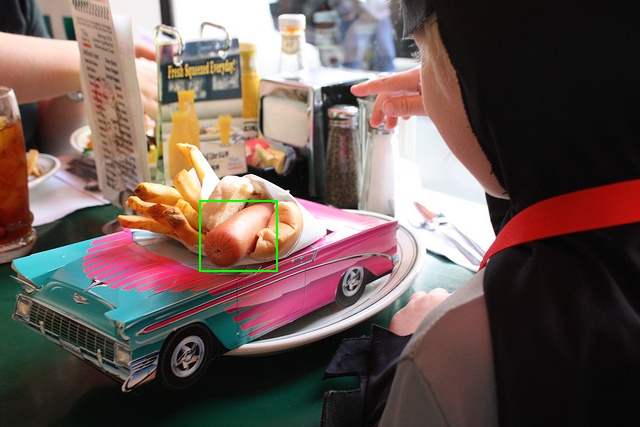

In [5]:
image_id, bbox = record["image_id"], record["bbox"]
url = f"http://images.cocodataset.org/val2014/COCO_val2014_{image_id:012d}.jpg"

# Download the image
print(f"Downloading {url}...")
response = requests.get(url)
image = Image.open(io.BytesIO(response.content))
draw = ImageDraw.Draw(image)

# COCO uses the XYWH format. PIL uses the XYXY format.
x1, y1, w, h = bbox
draw.rectangle((x1, y1, x1 + w, y1 + h), outline=(0, 255, 0), width=2)
display(image)